In [1]:
import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt
from FuzzySystemHandler import FuzzySystemHandler
import json
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import joblib
from sklearn.preprocessing import MinMaxScaler

## Fuzzy Sets

In [2]:
x_qual = np.linspace(0, 1, 100)

In [3]:
qual_lo = fuzz.trapmf(x_qual, [0, 0, .25, .5])
qual_md = fuzz.trimf(x_qual, [.25, .5, .75])
qual_hi = fuzz.trapmf(x_qual, [.5, .75, 1, 1])

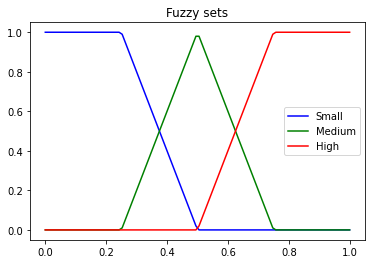

In [4]:
plt.plot(x_qual, qual_lo, 'b', linewidth=1.5, label='Small')
plt.plot(x_qual, qual_md, 'g', linewidth=1.5, label='Medium')
plt.plot(x_qual, qual_hi, 'r', linewidth=1.5, label='High')
plt.title('Fuzzy sets')
plt.legend()
plt.show()

## Fuzzy System

In [5]:
train = pd.read_csv("..\dataset\dadoscancer_2classes-train.csv")
train = train[[c for c in train.columns if 'Unnamed' not in c]]
valid = pd.read_csv("..\dataset\dadoscancer_2classes-valid.csv")
valid = valid[[c for c in valid.columns if 'Unnamed' not in c]]
test = pd.read_csv("..\dataset\dadoscancer_2classes-test.csv")
test = test[[c for c in test.columns if 'Unnamed' not in c]]


individual = json.load(open(r"..\results\cancer-sys.json", 'r'))

scaler: MinMaxScaler = joblib.load(r"..\results\cancer-sys-scaler.save")

In [6]:
binary_features = ['In PanCan Pathway Analysis', 'Post Initial Therapy', 'Prior Diagnosis', 'Radiation Therapy', 'Tissue Prospective Indicator', 'Ethnicity Category', 'Sex']

feature_sets = [(c, 2 if c in binary_features else 3) for c in train.columns.tolist() if c not in ['index', 'Class']]


fuzz_train = FuzzySystemHandler(train, feature_columns_sets=feature_sets,
                                target_column='Class', target_nsets=2, scaler=scaler)

fuzz_train.set_new_sets(individual)
fuzz_train.set_rules_system(individual) 

y_pred = fuzz_train.compute_result(train)

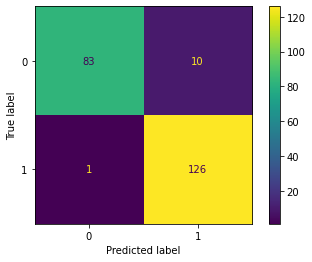

In [7]:
cm = confusion_matrix(train['Class'].values, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [8]:
fuzz_valid = FuzzySystemHandler(valid, feature_columns_sets=feature_sets,
                                target_column='Class', target_nsets=2, scaler=scaler)

fuzz_valid.set_new_sets(individual)
fuzz_valid.set_rules_system(individual) 

y_pred = fuzz_valid.compute_result(valid)

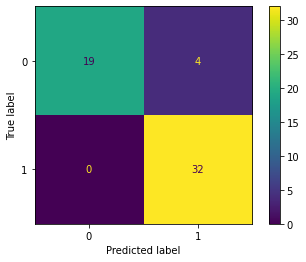

In [9]:
cm = confusion_matrix(valid['Class'].values, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [10]:
fuzz_test = FuzzySystemHandler(test, feature_columns_sets=feature_sets,
                                target_column='Class', target_nsets=2, scaler=scaler)

fuzz_test.set_new_sets(individual)
fuzz_test.set_rules_system(individual) 

y_pred = fuzz_test.compute_result(test)

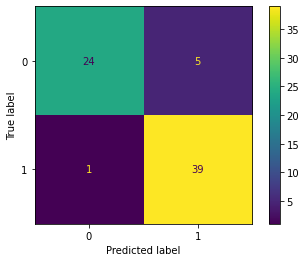

In [11]:
cm = confusion_matrix(test['Class'].values, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [12]:
columns = train.columns.tolist()
columns.remove('Class')
for rules in individual["rules"]:
    if rules["Enable"] == 1:
        print("IF ", end='')
        for idx in range(len(columns)):
            if rules["Antecedents"][idx] > 0:
                if columns[idx] in binary_features:
                    print(f"'{columns[idx]}' is {'True' if rules['Antecedents'][idx] == 1 else 'False'} {'AND ' if idx < len(columns) - 1 else ''}", end='')
                else:
                    ant = 'Small'
                    if rules["Antecedents"][idx] == 2:
                        ant = 'Medium'
                    if rules["Antecedents"][idx] == 3:
                        ant = 'High'
                    print(f"'{columns[idx]}' {ant} {'AND ' if idx < len(columns) - 1 else ''}", end='')
        print(f"THEN {'Benign' if rules['Consequent'] == 1 else 'Malignant'}")

IF 'Subtype' Small AND 'Winter Hypoxia Score' Small AND 'Tissue Prospective Indicator' is True THEN Malignant
IF 'Mutation Count' Medium AND 'Post Initial Therapy' is True AND THEN Malignant
IF 'Diagnosis Age' Medium AND THEN Malignant
IF 'Neoplasm Cancer Code' Medium AND THEN Malignant
IF 'Subtype' Small AND 'Ragnum Hypoxia Score' Small AND THEN Malignant
IF 'Cancer Type Detailed' Medium AND 'Radiation Therapy' is True AND THEN Malignant
IF 'Cancer Type Detailed' Medium AND 'Subtype' Medium AND 'Fraction Genome Altered' Small AND THEN Malignant
IF 'Diagnosis Age' Medium AND 'Radiation Therapy' is True AND THEN Malignant
IF 'Fraction Genome Altered' Small AND 'Mutation Count' Small AND 'Post Initial Therapy' is True AND THEN Benign
IF 'Buffa Hypoxia Score' Medium AND THEN Malignant
IF 'Neoplasm Cancer Code' Small AND 'Buffa Hypoxia Score' Small AND 'Winter Hypoxia Score' Small AND THEN Malignant


## GA

In [29]:
experiments = []
with open(r"..\results\log_ga.txt", 'r', encoding='utf-8') as log_ga:
    columns = log_ga.readline().split()
    print(columns)
    gen = []
    for line in log_ga:
        if 'Best' in line:
            continue
        if 'acc=' in line:
            continue
        if 'gen' in line:
            experiments.append(gen)
            gen = []
            continue
        
        gen.append([int(c) if idx < 2 else float(c) for idx, c in enumerate(line.split())]) 

experiments

['gen', 'nevals', 'avg', 'std', 'min', 'max']


[[[0, 300, 1.61449, 0.00896097, 1.5267, 1.62988],
  [1, 174, 1.59633, 0.0528295, 0.89637, 1.61992],
  [2, 203, 1.55933, 0.106352, 0.860627, 1.61175],
  [3, 207, 1.48007, 0.181517, 0.710855, 1.60945],
  [4, 191, 1.36655, 0.231712, 0.612078, 1.60716],
  [5, 208, 1.20827, 0.292215, 0.607884, 1.59601],
  [6, 212, 1.06288, 0.312028, 0.403891, 1.58958],
  [7, 203, 0.893877, 0.29931, 0.334495, 1.56777],
  [8, 210, 0.738991, 0.237827, 0.334495, 1.56019],
  [9, 199, 0.641861, 0.176321, 0.308335, 1.49284],
  [10, 188, 0.581402, 0.13429, 0.308335, 1.28011],
  [11, 197, 0.552291, 0.129197, 0.22617, 1.44615],
  [12, 206, 0.50282, 0.112382, 0.246998, 0.925335],
  [13, 202, 0.4833, 0.167362, 0.150552, 1.48557],
  [14, 206, 0.447264, 0.151917, 0.150552, 1.38666],
  [15, 191, 0.41059, 0.152048, 0.150552, 0.957185],
  [16, 196, 0.382298, 0.168976, 0.14075, 0.927486],
  [17, 186, 0.329082, 0.156472, 0.136752, 0.884629],
  [18, 207, 0.293551, 0.150077, 0.136752, 0.987668],
  [19, 210, 0.276962, 0.148998, 

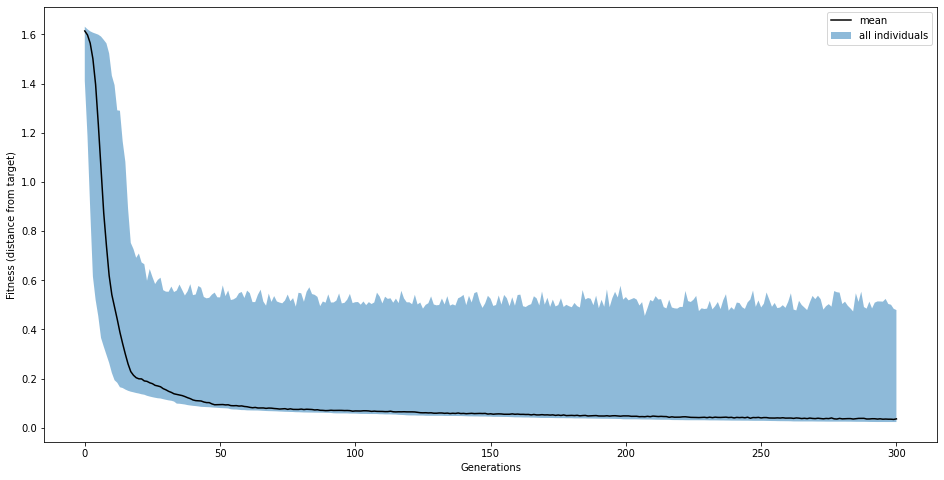

In [58]:
experiments = np.array(experiments)

plt.figure(figsize=(16, 8))
plt.fill_between(np.average(experiments[:, :, 0], axis=0), np.average(experiments[:, :, 4], axis=0), np.average(experiments[:, :, 5], axis=0), alpha=0.5, label='all individuals')
plt.plot(np.average(experiments[:, :, 2], axis=0), color='black', label='mean')

plt.legend()
plt.ylabel("Fitness (distance from target)")
plt.xlabel("Generations")
plt.show()

# for gen in experiments:
#     gen = np.array(gen)
#     plt.plot(np.asarray(gen)[:, 2])
# plt.show()